# Part 2: GAN

# Repeat the steps 1-6 with Least Square GAN and compare it with GAN results

# Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [7]:
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST


In [8]:
# Define transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])


transform = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Check dataset information
print("Train dataset length:", len(train_dataset))
print("Test dataset length:", len(test_dataset))

Train dataset length: 60000
Test dataset length: 10000


In [9]:
class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
               5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

In [11]:
# Break Data in mini batches
from torch.utils.data import DataLoader

batch_size = 100

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [13]:
# Setting Device configuration to get performance boost

device = torch.device('cuda' if torch.cuda.is_available() else ( 
    'mps' if torch.backends.mps.is_available() else 'cpu'))

# device = "cpu"
device

device(type='mps')

In [58]:
image_size = 784
hidden_size = 256

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim=100, output_dim=784):
        super(Generator, self).__init__()
        self.model =nn.Sequential(
            nn.Linear(latent_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh())

    def forward(self, z):
        return self.model(z)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, input_dim=784):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

# Initialize the generator and discriminator
latent_dim = 100
output_dim = 784
generator = Generator(latent_dim, output_dim)
discriminator = Discriminator(output_dim)

# Loss function
criterion = nn.MSELoss()

# Optimizers
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_loader = train_loader

d_losses, g_losses, real_scores, fake_scores = [], [], [], []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(data_loader):
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1)

        # Train Discriminator
        disc_optimizer.zero_grad()
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        z = torch.randn(batch_size, latent_dim)
        fake_images = generator(z)
        real_output = discriminator(real_images)
        fake_output = discriminator(fake_images.detach())  # detach to avoid generator gradients here
        disc_loss = 0.5 * (criterion(real_output, real_labels) + criterion(fake_output, fake_labels))
        disc_loss.backward()
        disc_optimizer.step()

        # Train Generator
        gen_optimizer.zero_grad()
        z = torch.randn(batch_size, latent_dim)
        fake_images = generator(z)
        fake_output = discriminator(fake_images)
        gen_loss = 0.5 * criterion(fake_output, real_labels)
        gen_loss.backward()
        gen_optimizer.step()

        if (i+1) % 200 == 0:
            d_losses.append(disc_loss.item())
            g_losses.append(gen_loss.item())
            real_scores.append(real_output.mean().item())
            fake_scores.append(fake_output.mean().item())
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], "
                  f"Discriminator Loss: {disc_loss.item():.4f}, Generator Loss: {gen_loss.item():.4f}")

# Save the trained generator
torch.save(generator.state_dict(), 'generator.pth')


Epoch [1/20], Step [200/600], Discriminator Loss: 0.0330, Generator Loss: 0.3127
Epoch [1/20], Step [400/600], Discriminator Loss: 0.0027, Generator Loss: 0.4540
Epoch [1/20], Step [600/600], Discriminator Loss: 0.1015, Generator Loss: 0.4995
Epoch [2/20], Step [200/600], Discriminator Loss: 0.0597, Generator Loss: 0.4718
Epoch [2/20], Step [400/600], Discriminator Loss: 0.0278, Generator Loss: 0.4495
Epoch [2/20], Step [600/600], Discriminator Loss: 0.1876, Generator Loss: 0.4124
Epoch [3/20], Step [200/600], Discriminator Loss: 0.0659, Generator Loss: 0.4063
Epoch [3/20], Step [400/600], Discriminator Loss: 0.0542, Generator Loss: 0.4029
Epoch [3/20], Step [600/600], Discriminator Loss: 0.1293, Generator Loss: 0.4161
Epoch [4/20], Step [200/600], Discriminator Loss: 0.0950, Generator Loss: 0.4382
Epoch [4/20], Step [400/600], Discriminator Loss: 0.1305, Generator Loss: 0.3981
Epoch [4/20], Step [600/600], Discriminator Loss: 0.1342, Generator Loss: 0.4525
Epoch [5/20], Step [200/600]

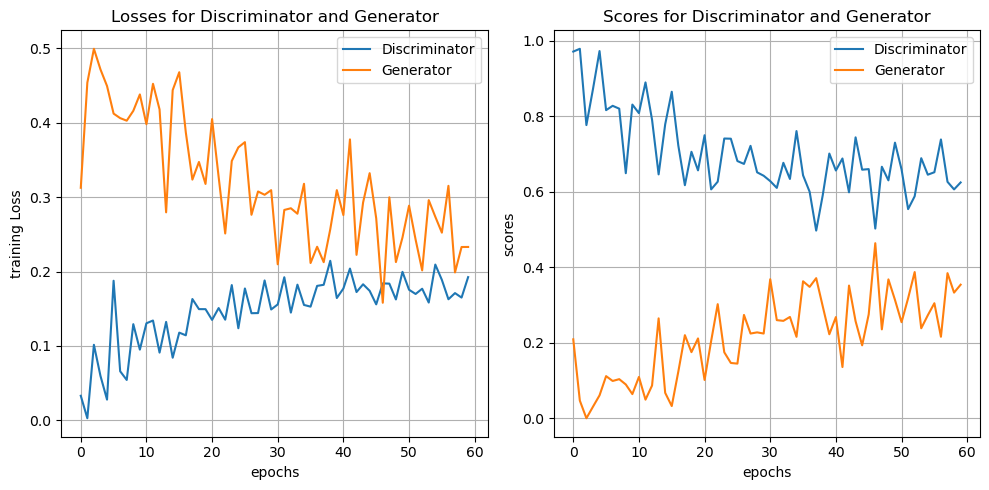

In [61]:
def plot_side_by_side(d_losses, g_losses, real_scores, fake_scores):
    
    plt.figure(figsize=(10,5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(d_losses, '-')
    plt.plot(g_losses, '-')
    plt.xlabel("epochs")
    plt.ylabel("training Loss")
    plt.legend(['Discriminator', 'Generator'])
    plt.grid(True)
    plt.title("Losses for Discriminator and Generator")
    
    # Plot scores
    plt.subplot(1, 2, 2)
    plt.plot(real_scores, '-')
    plt.plot(fake_scores, '-')
    plt.xlabel("epochs")
    plt.ylabel("scores")
    plt.legend(['Discriminator', 'Generator'])
    plt.grid(True)
    plt.title("Scores for Discriminator and Generator")
    
    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()
    
plot_side_by_side(d_losses, g_losses, real_scores, fake_scores)